# LSTM - enhanced deep Koopman 

## NeuroMANCER and Dependencies

In [1]:
import os
import sys
import time as tim

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.problem import Problem
from neuromancer.slim import slim
from neuromancer.system import Node, System
from neuromancer.trainer import Trainer

sys.path.append(os.path.abspath(".."))
from src.datasets import get_data_loaders, simulate_two_tank
from src.plot import plot_results

%load_ext autoreload
%autoreload 2

seed = 0
torch.manual_seed(seed)

## Generate trajectories from ODE system 

In [2]:
delay = 20
n_samples = 20000

In [3]:
model, (train_data, dev_data, test_data) = simulate_two_tank(
    n_samples, n_sequences=3, delay=delay, noise_variance=0.1, seed=seed
)

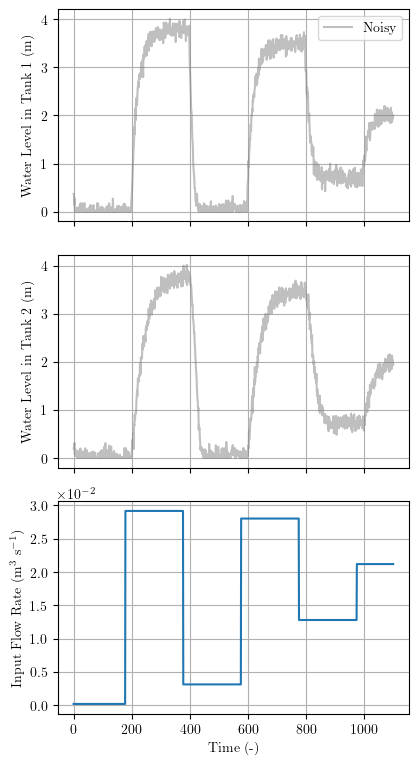

In [4]:
fig = plot_results(
    train_data["U"][:1100],
    {"Noisy": train_data["Y"][:1100]},
)

## Create training data of sampled trajectories


In [5]:
nsteps = 80  # number of prediction horizon steps in the loss function
bs = 100  # minibatching batch size
time = 80  # number of lookback window as input to lstm
train_loader, dev_loader, test_loader = get_data_loaders(
    model,
    {"train": train_data, "dev": dev_data, "test": test_data},
    n_samples,
    nsteps,
    time,
    bs,
)

In [6]:
max_length = float("-inf")
min_length = float("inf")

for batch in train_loader:
    # Assuming each batch contains input tensors
    # You can modify this based on your data structure

    for key, tensor in batch.items():
        # Get the length of the tensor
        try:
            length = tensor.shape[
                0
            ]  # Assuming tensor is of shape (length, ...)

            # Update max_length and min_length
            max_length = max(max_length, length)
            min_length = min(min_length, length)
        except:
            pass

print("Longest tensor length:", max_length)
print("Shortest tensor length:", min_length)

Longest tensor length: 100
Shortest tensor length: 49


## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [7]:
# model parameters
ny = model.ny
nx = model.nx
nu = model.nu
nx_koopman = 40
n_hidden = 60
n_layers = 2
lstm_features = 8

**LSTM + Encoder and Decoder networks** 

In [8]:
f_yu = blocks.LSTMBlock(ny + nu, lstm_features)


def f_yuT(data):
    s = data.shape
    res = f_yu(data.reshape(s[0] * nsteps, time, ny + nu))
    return res.reshape(s[0], nsteps, lstm_features)


extract_time_features = Node(
    f_yuT, ["timeYU"], ["time_enc"], name="extract_time_features"
)

extract_time_features_0 = Node(
    f_yu, ["timeYU0"], ["time_enc0"], name="extract_time_features_0"
)

In [9]:
def stack(a, b):
    return torch.cat((a, b), dim=-1)

In [10]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny + lstm_features,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
# initial condition encoder
encode_Y0 = Node(f_y, ["Y0_te"], ["x"], name="encoder_Y0")
# observed trajectory encoder
encode_Y = Node(f_y, ["Y_te"], ["x_latent"], name="encoder_Y")

stack_Y0 = Node(stack, ["Y0", "time_enc0"], ["Y0_te"], name="stack_Y0")
stack_Y = Node(stack, ["Y", "time_enc"], ["Y_te"], name="stack_Y")

In [11]:
# matrice B
K_B = torch.nn.Linear(nu, nx_koopman, bias=False)
encode_U = Node(K_B, ["U"], ["u_real"], name="encoder_U")

In [12]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(
    nx_koopman,
    ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
# predicted trajectory decoder
decode_y = Node(f_y_inv, ["x"], ["yhat"], name="decoder_y")

In [13]:
# instantiate Koopman operator matrix
stable = True  # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(
        nx_koopman, nx_koopman, sigma_min=0.01, sigma_max=1.0, bias=False
    )
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.0 * (K_reg_error == 0.0)
    K_reg_loss.name = "SVD_loss"
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [14]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K (x_k + u_k)
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [15]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ["x", "u_real"], ["x"], name="K")

# latent Koopmann rollout
dynamics_model = System([Koopman], name="Koopman", nsteps=nsteps)

In [16]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [
    extract_time_features,
    extract_time_features_0,
    stack_Y0,
    stack_Y,
    encode_Y0,
    encode_Y,
    encode_U,
    dynamics_model,
    decode_y,
]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [17]:
# variables
Y = variable("Y")  # observed
yhat = variable("yhat")  # predicted output
x_latent = variable(
    "x_latent"
)  # encoded output trajectory in the latent space
# u_latent = variable('u_latent')  # encoded input trajectory in the latent space
u_real = variable("u_real")  # real input trajectory
x = variable("x")  # Koopman latent space trajectory

# xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10.0 * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.0 * (yhat[:, 1, :] == Y[:, 1, :]) ^ 2
onestep_loss.name = "onestep_loss"

# latent trajectory tracking loss
x_loss = 1.0 * (x[:, 1:-1, :] == x_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [18]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [ ]:
print(problem.input_keys)
print(problem.output_keys)

['u_real', 'x', 'timeYU0', 'U', 'yhat', 'Y0', 'Y0_te', 'x_latent', 'Y_te', 'time_enc0', 'Y', 'timeYU', 'time_enc']
['u_real', 'penalty_loss', 'x', 'objective_loss', 'C_eq_violations', 'C_ineq_values', 'yhat', 'C_ineq_violations', 'x_latent', 'Y0_te', 'C_values', 'Y_te', 'loss', 'time_enc0', 'C_eq_values', 'C_violations', 'time_enc']


## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [20]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    patience=200,
    warmup=100,
    epochs=1500,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

Long running code approx 20minutes

In [21]:
# %% train
start = tim.time()
best_model = trainer.train()
problem.load_state_dict(best_model)
end = tim.time()

epoch: 0  train_loss: 23.144784927368164
epoch: 1  train_loss: 16.66706657409668
epoch: 2  train_loss: 13.081097602844238
epoch: 3  train_loss: 8.691645622253418
epoch: 4  train_loss: 7.58457612991333
epoch: 5  train_loss: 8.199498176574707
epoch: 6  train_loss: 9.072684288024902
epoch: 7  train_loss: 7.763721942901611
epoch: 8  train_loss: 7.069520473480225
epoch: 9  train_loss: 7.132133483886719
epoch: 10  train_loss: 7.2192816734313965
epoch: 11  train_loss: 7.131143569946289
epoch: 12  train_loss: 6.796791076660156
epoch: 13  train_loss: 6.847384929656982
epoch: 14  train_loss: 6.357862949371338
epoch: 15  train_loss: 6.729769229888916
epoch: 16  train_loss: 6.520901203155518
epoch: 17  train_loss: 6.788140773773193
epoch: 18  train_loss: 6.628438472747803
epoch: 19  train_loss: 6.675907611846924
epoch: 20  train_loss: 6.488259792327881
epoch: 21  train_loss: 6.679357528686523
epoch: 22  train_loss: 6.2111687660217285
epoch: 23  train_loss: 6.182106018066406
epoch: 24  train_loss: 

In [31]:
# elapsed time
print(f"Elapsed time training: {end - start:.0f} s")

Elapsed time training: 1523 s


In [32]:
torch.save(best_model, f"results/LSTM_{lstm_features}.pth")

## System Identification results

In [28]:
best_model = torch.load("../results/LSTM_8.pth")

In [22]:
n_test = 2400  # test_data["Y"].shape[0]

In [29]:
# update the rollout length based on the test data
problem.nodes[7].nsteps = n_test - time

In [30]:
# TODO: find out why does this crash with longer periods
test_datadict = test_loader.dataset.datadict
res = problem.nodes[1]({"timeYU0": test_datadict["timeYU0"][0:1, :, :]})
res1 = problem.nodes[2]({
    "time_enc0": res["time_enc0"],
    "Y0": test_datadict["Y0"][0:1, :, :],
})
res2 = problem.nodes[4](res1)
# resU = problem.nodes[6]({"U": test_datadict["U"].reshape(1, n_test - time, 1)})
resU = problem.nodes[6]({
    "U": test_datadict["U"][: n_test // time, :, :].reshape(1, n_test, 1)
})
res3 = problem.nodes[7]({"x": res2["x"], "u_real": resU["u_real"]})
res4 = problem.nodes[8](res3)

In [31]:
pred_traj = res4["yhat"][:, :-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_datadict["Y"][:30, :, :].detach().numpy().reshape(-1, nx).T
input_traj = (
    test_datadict["U"][:30, :, :]
    .reshape(1, 2400, 1)
    .detach()
    .numpy()
    .reshape(-1, nu)
    .T
)

In [32]:
mean_x = model.stats["Y"]["mean"]
std_x = model.stats["Y"]["std"]
mean_u = model.stats["U"]["mean"]
std_u = model.stats["U"]["std"]


def normalize(x, mean, std):
    return (x - mean) / std


def denormalize(x, mean, std):
    return x * std + mean


np.save("results/test_pred_derek.npy", denormalize(pred_traj.T, mean_x, std_x))

pred = {
    "h1": denormalize(pred_traj.T, mean_x, std_x)[:, 0],
    "h2": denormalize(pred_traj.T, mean_x, std_x)[:, 1],
}
scipy.io.savemat("results/pred_sim_DeReK.mat", pred)
true = {
    "h1": denormalize(true_traj.T, mean_x, std_x)[:, 0],
    "h2": denormalize(true_traj.T, mean_x, std_x)[:, 1],
}
scipy.io.savemat("data/true_sim.mat", true)

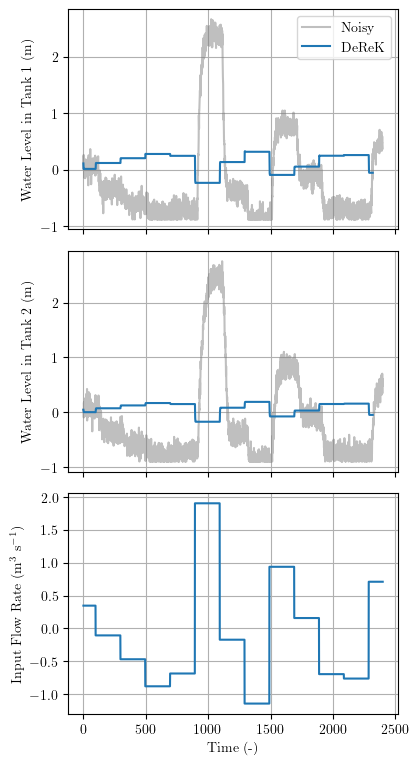

In [34]:
fig = plot_results(input_traj.T, {"Noisy": true_traj.T, "DeReK": pred_traj.T})

In [47]:
# save A and B matrices, where A = K.effective_W() and B = K_B.weight
A = K.effective_W().detach().numpy()
B = K_B.weight.detach().numpy()

np.save("results/A_DeReK_noise.npy", A)
np.save("results/B_DeReK_noise.npy", B)

In [55]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eig = eig.detach().numpy()
eig = eig[np.argsort(eig)[::-1]]

In [57]:
np.save("results/eig_derek.npy", eig)